In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import plotly.graph_objects as go
from utils.scenario_creator import create_weather_BMG_scens, plot_pdf
from utils.functions import get_data_fromNSRDB
import json
import time

# Crear escenarios meteorológicos

### Seleccionar ubicación

In [13]:
location = {"lat":4.433, "lon":-69.8, "name":"Cumaribo", "name_data" : "cumaribo"}
#location = {"lat":12.583, "lon":-81.706, "name":"San Andrés"}

### Importar datos de la NSRDB

In [5]:
df = pd.DataFrame()

for i in [2015,2016,2017,2018,2019,2020]:
    df2, info2 = get_data_fromNSRDB(location["lat"], location["lon"], i)
    time.sleep(2)
    df = pd.concat([df, df2])

date_vec = np.vectorize(datetime)
df_index = date_vec(df.Year.values,df.Month.values,df.Day.values, df.Hour.values, df.Minute.values, tzinfo=None)
df.index = df_index

df

Year  Month  Day  Hour  Minute  GHI  DHI  DNI  \
2015-01-01 00:00:00  2015      1    1     0       0    0    0    0   
2015-01-01 01:00:00  2015      1    1     1       0    0    0    0   
2015-01-01 02:00:00  2015      1    1     2       0    0    0    0   
2015-01-01 03:00:00  2015      1    1     3       0    0    0    0   
2015-01-01 04:00:00  2015      1    1     4       0    0    0    0   
...                   ...    ...  ...   ...     ...  ...  ...  ...   
2020-12-31 19:00:00  2020     12   31    19       0    0    0    0   
2020-12-31 20:00:00  2020     12   31    20       0    0    0    0   
2020-12-31 21:00:00  2020     12   31    21       0    0    0    0   
2020-12-31 22:00:00  2020     12   31    22       0    0    0    0   
2020-12-31 23:00:00  2020     12   31    23       0    0    0    0   

                     Wind Speed  Temperature  Solar Zenith Angle  
2015-01-01 00:00:00         0.9         21.0              160.95  
2015-01-01 01:00:00         0.9         21.0              153.64  
2015-01-01 02:00:00         1.0         21.0              141.99  
2015-01-01 03:00:00         1.4         21.0              128.92  
2015-01-01 04:00:00         2.1         21.0              115.32  
...                         ...          ...                 ...  
2020-12-31 19:00:00         1.0         24.6              109.60  
2020-12-31 20:00:00         0.9         24.2              123.29  
2020-12-31 21:00:00         0.9         23.8              136.64  
2020-12-31 22:00:00         0.9         23.4              149.07  
2020-12-31 23:00:00         0.9         23.0              158.78  

[52560 rows x 11 columns]

### Gráficas de los históricos

In [6]:
# FIGURA IRRADIANCIA
fig = go.Figure(data=[go.Scatter(x = df.index, y=df["GHI"], name='GHI')])
fig.update_layout(title=f'Irradiancia en {location["name"]}. 2015-2020', xaxis_title="Fecha", yaxis_title="W/m^2", font=dict(size=14))
fig.show()

# FIGURA VELOCIDAD DEL VIENTO
fig = go.Figure(data=[go.Scatter(x = df.index, y=df["Wind Speed"], name='GHI', line_color ='red')])
fig.update_layout(title=f'Velocidad del viento en {location["name"]}. 2015-2020', xaxis_title="Fecha", yaxis_title="m/s", font=dict(size=14))
fig.show()

In [7]:
fig_data = {"month":1, "hour": 2}

month_name = datetime(1900, fig_data["month"], 1).strftime('%B')

fig = go.Figure(data=[go.Scatter(x = df.index[np.logical_and(df["Year"] == year, df["Month"] == fig_data["month"])],
                                y=df.loc[np.logical_and(df["Year"] == year, df["Month"] == fig_data["month"]), "Wind Speed"].to_numpy(), 
                                name=f'{year}') for year in [2015,2016,2017,2018,2019,2020]])
fig.update_layout(title=f'Velocidad del viento en {location["name"]}. {month_name}', xaxis_title="Fecha", yaxis_title="m/s", font=dict(size=14), xaxis_range=[df.index[0],df.index[-1]])
fig.show()

fig = go.Figure(data=[go.Scatter(x = df.index[np.logical_and.reduce([df["Year"] == year, df["Month"] == 1, df.Hour == 14])], 
                                y=df.loc[np.logical_and.reduce([df["Year"] == year, df["Month"] == 1, df.Hour == 14]), "Wind Speed"].to_numpy(), 
                                name=f'{year}', mode='markers') for year in [2015,2016,2017,2018,2019,2020]])
fig.update_layout(title=f'Velocidad del viento en {location["name"]}. {month_name} a las {fig_data["hour"]}:00', xaxis_title="Fecha", yaxis_title="m/s", font=dict(size=14), xaxis_range=[df.index[0],df.index[-1]])
fig.show()

### Gráfico de las funciones de probabilidad para un mes específico

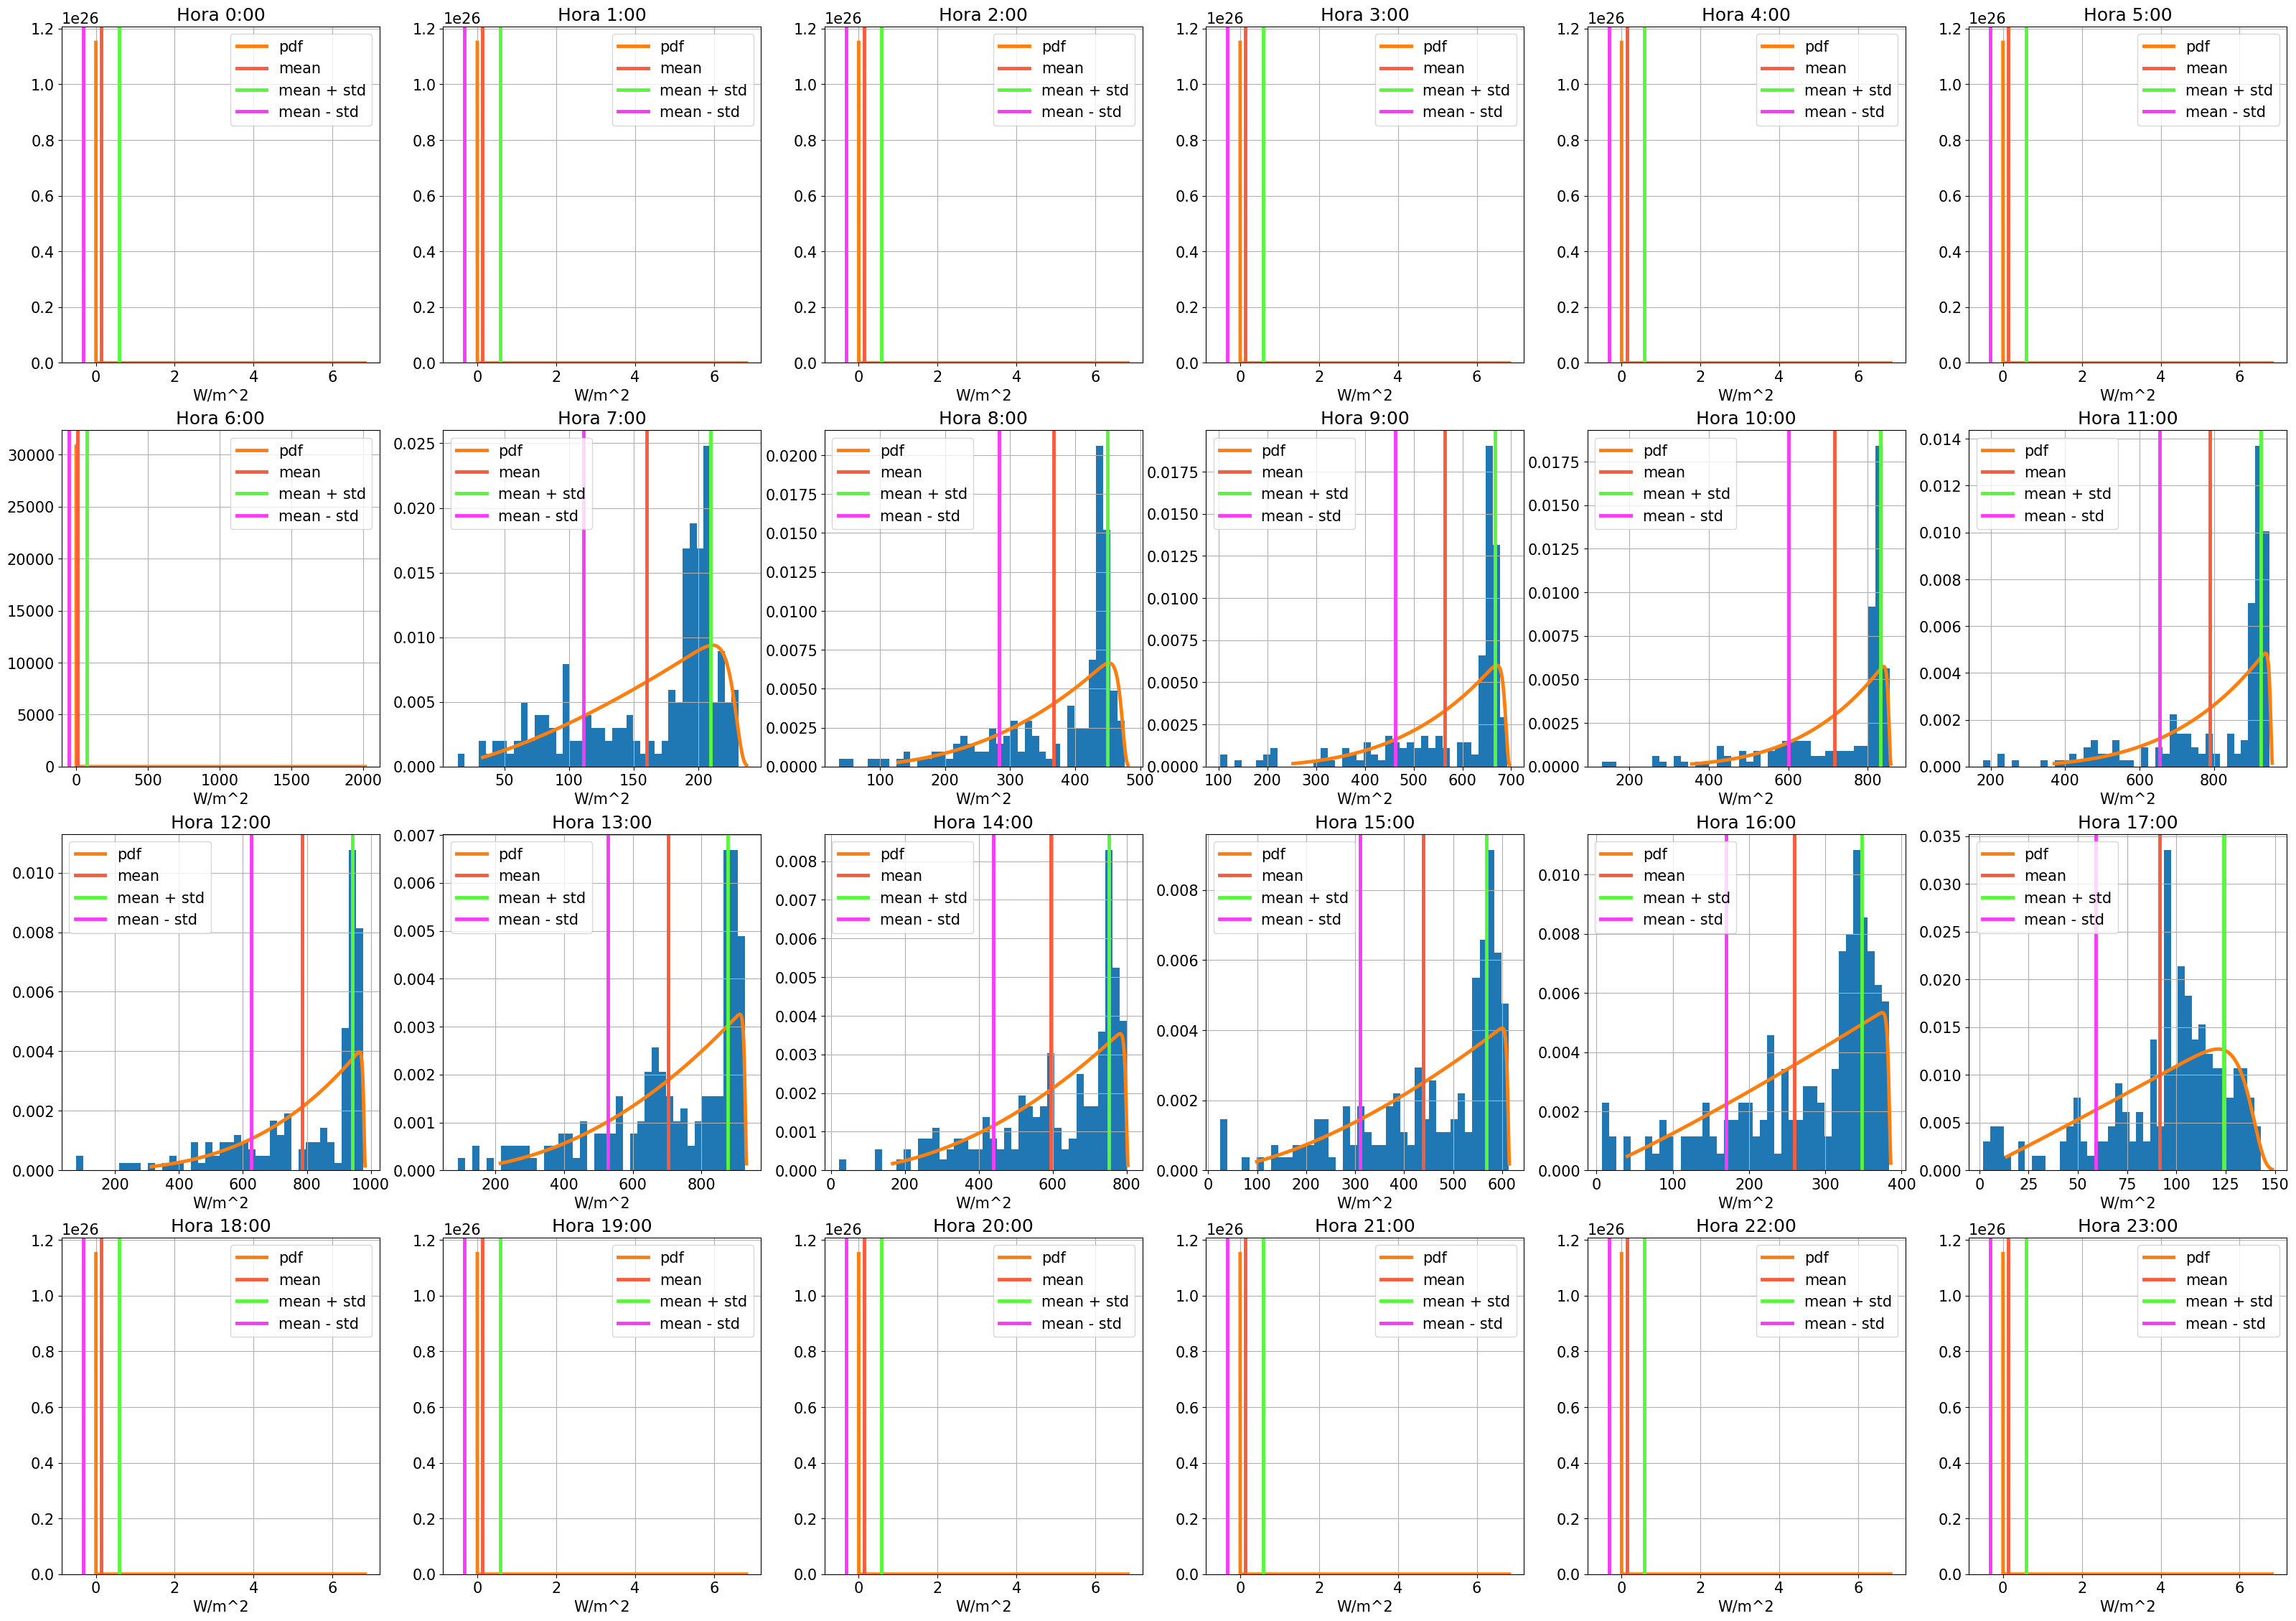

In [8]:
from scipy.stats import exponweib

fig = plot_pdf(df = df, pdf = exponweib, col_data = "GHI", month = 1, units="W/m^2")

### Creación de escenarios

In [9]:
GHI_scens, GHI_prob = create_weather_BMG_scens(df=df, pdf_scipy=exponweib, col="GHI", seed=15)
wind_scens, wind_prob = create_weather_BMG_scens(df=df, pdf_scipy=exponweib, col="Wind Speed", seed=15)

Could not assign random data. Historical assignees
Could not assign random data. Historical assignees
Could not assign random data. Historical assignees
Could not assign random data. Historical assignees
Could not assign random data. Historical assignees
Could not assign random data. Historical assignees
Could not assign random data. Historical assignees
Could not assign random data. Historical assignees
Could not assign random data. Historical assignees


c:\Users\Nicolas\Documents\GitHub\Tesis_Maestria\venv\lib\site-packages\scipy\stats\_continuous_distns.py:1676: RuntimeWarning:

invalid value encountered in add



### Guardar escenarios creados

In [14]:
abrv_name = location["name_data"]

GHI_scens[GHI_prob.keys()].to_csv(f'Escenarios/GHI_scens_{abrv_name}.csv', index = False)
with open(f'Escenarios/GHI_prob_{abrv_name}.json', "w") as fp:
    json.dump(GHI_prob,fp) 

wind_scens[wind_prob.keys()].to_csv(f'Escenarios/wind_scens_{abrv_name}.csv', index = False)
with open(f'Escenarios/wind_prob_{abrv_name}.json', "w") as fp:
    json.dump(wind_prob,fp) 

In [15]:
data_fig = [go.Scatter(y=df.loc[df["Year"] == 2020, "GHI"].to_numpy(), name='Históricos de 2020')]
data_fig.extend([go.Scatter(y=GHI_scens[key], name=f'{key} ({np.round(GHI_prob[key],3)})') for key in GHI_prob.keys()])

fig = go.Figure(data=data_fig)
fig.update_layout(title="Escenarios irradiancia", xaxis_title="Fecha", yaxis_title="W/m^2", font=dict(size=14))
fig.show()

In [16]:
data_fig = [go.Scatter(y=df.loc[df["Year"] == 2020, "Wind Speed"].to_numpy(), name='Históricos de 2020')]
data_fig.extend([go.Scatter(y=wind_scens[key], name=f'{key} ({np.round(wind_prob[key],3)})') for key in wind_prob.keys()])

fig = go.Figure(data=data_fig)
fig.update_layout(title="Escenarios velocidad del viento", xaxis_title="Fecha", yaxis_title="m/s", font=dict(size=14))
fig.show()